# Reconocimiento de Imágenes en CIFAR10

Para experimentar con el reconocimiento de imágenes y la clasificación se estudia el dataset *CIFAR10*, el cual contiene 60.000 imagenes de 32 $\times$ 32 (pixeles), donde cada imagen pertenece a una de las diez clases, clasificación excluyente (gato, perro, rana, caballo, pájaro, ciervo, avión, automóvil, camión y barco). Los datos vienen estructurado en un formato RGB, donde cada imagen (fila del dataset) corresponde a 3072 características, dividido en los 3 canales de RGB (1024 cada uno) correspondiente a cada imagen.  
Los datos vienen separados en datos de entrenamiento y de pruebas, para un estudio eficiente con las distintas arquitecturas que ofrecen las *redes neuronales*, además de analizar distintas representaciones de imágenes.

In [1]:
import os    
os.environ['THEANO_FLAGS'] = "device=gpu,floatX=float32"    
import theano
print theano.config

ERROR (theano.sandbox.cuda): nvcc compiler not found on $PATH. Check your nvcc installation and try again.


floatX (('float64', 'float32', 'float16')) 
    Doc:  Default floating-point precision for python casts.

Note: float16 support is experimental, use at your own risk.
    Value:  float32

warn_float64 (('ignore', 'warn', 'raise', 'pdb')) 
    Doc:  Do an action when a tensor variable with float64 dtype is created. They can't be run on the GPU with the current(old) gpu back-end and are slow with gamer GPUs.
    Value:  ignore

cast_policy (('custom', 'numpy+floatX')) 
    Doc:  Rules for implicit type casting
    Value:  custom

int_division (('int', 'raise', 'floatX')) 
    Doc:  What to do when one computes x / y, where both x and y are of integer types
    Value:  int

device (cpu, gpu*, opencl*, cuda*) 
    Doc:  Default device for computations. If cuda* or opencl*, change thedefault to try to move computation to the GPU. Do not use upper caseletters, only lower case even if NVIDIA uses capital letters.
    Value:  gpu

init_gpu_device (, gpu*, opencl*, cuda*) 
    Doc:  Initialize 

[[ 59  43  50 ..., 140  84  72]
 [154 126 105 ..., 139 142 144]
 [255 253 253 ...,  83  83  84]
 ..., 
 [ 71  60  74 ...,  68  69  68]
 [250 254 211 ..., 215 255 254]
 [ 62  61  60 ..., 130 130 131]]
min value 0
max value 255


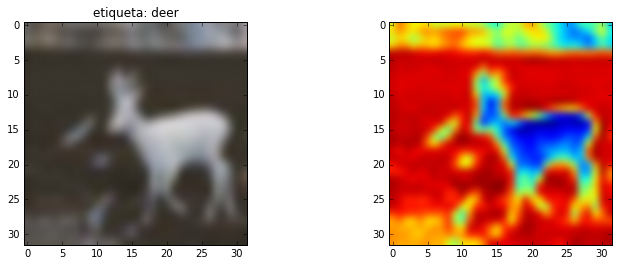

In [4]:
def unpickle(file):
    import cPickle
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict

dict1 = unpickle("data/data_batch_1")
X = dict1["data"]
print X
Y = dict1['labels']
print "min value" ,min(X[0])
print "max value" ,max(X[0])

label_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

import numpy as np

def ver_imagen(X,Y,n):
    aux = X[n].reshape(3,1024).copy()
    imagen = np.zeros((32,32,3))
    canal_r = aux[0].reshape(32,32)
    canal_g = aux[1].reshape(32,32)
    canal_b = aux[2].reshape(32,32)
    for i in range(len(aux)):
        imagen[:,:,i] = aux[i].reshape(32,32)
    
    import matplotlib.pyplot as plt
    f,ax = plt.subplots(1,2,figsize=(12,4))
    ax[0].set_title("etiqueta: "+label_names[Y[n]])
    ax[0].imshow(imagen, interpolation="bicubic")

    ax[1].imshow(canal_r, interpolation="bicubic")
    ax[1].imshow(canal_g, interpolation="bicubic")
    ax[1].imshow(canal_b, interpolation="bicubic")
    plt.show()
    
ver_imagen(X,Y,20)

### Cargar Dataset

In [5]:
from scipy.misc import imread
import cPickle as pickle
import numpy as np
import os

def load_CIFAR_one(filename):
    with open(filename, "rb") as f:
        datadict = pickle.load(f)
        X = datadict["data"]
        Y = datadict["labels"]
        return X, np.array(Y)

def load_CIFAR10(PATH):
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(PATH, "data_batch_%d" % (b, ))
        X, Y = load_CIFAR_one(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    
    Xte, Yte = load_CIFAR_one(os.path.join(PATH, "test_batch"))
    
    #adding Xval
    index = np.arange(np.shape(Xtr)[0]) #filas 
    np.random.shuffle(index) #permutan las filas
    X = Xtr[index, :] #matriz permutada
    Y = Ytr[index]
    #l =  np.random.randint(1000,5000) #entrego 4259
    l = 4259
    Xval,Xtr = np.split(X,[l])
    Yval,Ytr = np.split(Y,[l])
    
    return Xtr, Ytr, Xte, Yte,Xval,Yval

x_train,y_train, x_test,y_test, x_val,y_val = load_CIFAR10('data/')

#ESCALAR

x_train = x_train/255.0
x_test = x_test/255.0
x_val = x_val/255.0


print 'Training set shape: ',x_train.shape
print 'Validation set shape: ',x_val.shape
print 'Test set shape: ',x_test.shape 

Training set shape:  (45741, 3072)
Validation set shape:  (4259, 3072)
Test set shape:  (10000, 3072)


En la celda anterior se carga el dataset de CIFAR10, el cual está dividido en *batchs*. Se crean las matrices $X_{train}$, $Y_{train}$, $X_{test}$, $Y_{test}$ y $X_{val}$, $Y_{val}$. El conjunto de validación es creado a partir del *training set* y este no supera los 5000 datos. Las filas de estas matrices representan a cada imagen del dataset, siendo los valores de la fila valores enteros de 0 a 255, que representan los valores de los colores que vienen por los canales *R*,*G* y *B*.  
Se puede observar que la matriz $X_{train}$ posee 45741 filas, es decir, 45741 imagenes de entrenamiento. Por otro lado $X_{val}$ posee 4259 imágenes de validación y $X_{test}$ 10000 imágenes de prueba. Las 10 etiquetas están codificadas en números enteros del 0 al 9.  

En esta celda se escala la representación matricial de píxeles de las imágenes, para poder trabajarlas de forma apropiada, normalizando por la intensidad máxima 255, dejando cada atributo en un intervalo entre 0 y 1.

## A) Ajuste/Preprocesamiento

In [6]:
import keras
x_train = x_train.reshape((x_train.shape[0],32,32,3))
#x_train = x_train.transpose([0, 2, 3, 1]) #only if 'tf' dim-ordering is to be used
x_test= x_test.reshape((x_test.shape[0],32,32,3))
#x_test= x_test.transpose([0, 2, 3, 1])#remove if 'th' dim-ordering is to be used
y_train = keras.utils.np_utils.to_categorical(y_train, 10)
y_test = keras.utils.np_utils.to_categorical(y_test, 10)

Using Theano backend.


## B) Definir una CNN

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D

model = Sequential()
model.add(Convolution2D(64, 3, 3, border_mode='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

/usr/local/lib/python2.7/dist-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode='max')
/usr/local/lib/python2.7/dist-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode='max')
/usr/local/lib/python2.7/dist-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode='max')


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 32, 32, 64)    1792        convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 32, 32, 64)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 16, 16, 64)    0           activation_1[0][0]               
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 16, 16, 64)    36928       maxpooling2d_1[0][0]             
___________________________________________________________________________________________

## C) Entrenar la red (SGD)

In [8]:
from keras.optimizers import SGD, rmsprop
from keras.callbacks import LearningRateScheduler
import math
def step_decay(epoch):
    initial_lrate = 0.001
    lrate = initial_lrate * math.pow(0.5, math.floor((1+epoch)/5))
    lrate = max(lrate,0.00001)
    return lrate
opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
lrate = LearningRateScheduler(step_decay)
model.compile( optimizer=opt, loss='binary_crossentropy' )
hist = model.fit(x_train, y_train,batch_size=100,nb_epoch=25,
validation_data=(x_test, y_test),shuffle=True,callbacks=[lrate],verbose=1,)

Train on 45741 samples, validate on 10000 samples
Epoch 1/25
23600/45741 [==============>...............] - ETA: 196s - loss: 0.3251

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/ultratb.py", line 358, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/usr/lib/python2.7/inspect.py", line 1044, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/usr/lib/python2.7/inspect.py", line 1004, in getframeinfo
    filename = getsourcefile(frame) or getfile(frame)
  File "/usr/lib/python2.7/inspect.py", line 454, in getsourcefile
    if hasattr(getmodule(object, filename), '__loader__'):
  File "/usr/lib/python2.7/inspect.py", line 490, in getmodule
    for modname, module in sys.mo

IndexError: string index out of range

In [ ]:
history_dict1 = hist.history
loss_values1 = history_dict1['loss']
val_loss_values1 = history_dict1['val_loss']
epochs1 = range(1, len(loss_values1) + 1)
f, axarr = plt.subplots(1,figsize=(14,5))
axarr.plot(epochs1, loss_values1, 'bo', label = "Training set")
axarr.plot(epochs1, val_loss_values1, 'b+', label = "Test set")
axarr.set_title('Error de CNN con SGD')
axarr.set_ylim(0,1)
axarr.set_xlabel('Epochs')
axarr.set_ylabel('Loss')
axarr.legend(loc="center right", fancybox= True)
plt.show()

## D) Entrenar la red (RMSProp)

In [ ]:
from keras.optimizers import SGD, rmsprop
opt = rmsprop(lr=0.001, decay=1e-6)
model.compile( ... )
model.fit(x_train, y_train,batch_size=batch_size,nb_epoch=epochs,
validation_data=(x_test, y_test),shuffle=True)

## E) Variar red

In [ ]:
model = Sequential()
model.add(Convolution2D(64, 3, 3, border_mode='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
...

## F) Mas variaciones

In [ ]:
...
model.add(Convolution2D(128, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution2D(128, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3, subsample=(2, 2), border_mode='valid'))
...

## G) Regularizar

In [ ]:
datagen = ImageDataGenerator(
    featurewise_center=False, # set input mean to 0 over the dataset
    samplewise_center=False, # set each sample mean to 0
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    samplewise_std_normalization=False, # divide each input by its std
    zca_whitening=False, # apply ZCA whitening
    rotation_range=0, # randomly rotate images (degrees, 0 to 180)
    width_shift_range=0.1, # randomly shift images horizontally (fraction of width)
    height_shift_range=0.1, # randomly shift images vertically (fraction of height)
    horizontal_flip=True, # randomly flip images
    vertical_flip=False) # randomly flip images
datagen.fit(x_train)
model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
        steps_per_epoch=x_train.shape[0]// batch_size,
        epochs=epochs,validation_data=(x_test, y_test))

## H) mas